# Assignment 2 -- Text classification

### by Kolokathi Fotini (DS3516007)   and   Spartalis Iosif (DS3516018)

* The purpose of this assignment is to create one or more *email filters* in order to classify the emails as **'spam'** or **'ham'**.
We are going to use **Ling-Spam** data from [Aueb NLP Group](http://nlp.cs.aueb.gr/software.html) and more particularly we will use the bare version of the corpus (./lingspam_public/lingspam_public/bare folder) in which Lemmatiser and stop-list are disabled.

* The process that we are going to follow is the following:

![](images/process.PNG)

* Now we are going to analyze step-by-step the whole process we will follow in order to create e-mail filters based on different machine learning algorithms.We must mention that there are a lot of comments inside the code for technical and other issues (i.e  description of libraries etc) that can be very helpful for understanding the implementation better.



* Here, there are all the functions that will be called.There are detailed comments for each one inside the code and we are going to describe each one at the corresponding step that it is called.  

In [11]:
import os
import re
import nltk
import string
import time
import random
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from itertools import cycle


 
class LemmaTokenizer(object):
    """custom tokenizer with lemmatizer to be used in sklearn countVectorizer"""
    def __init__(self):
        self.tkzer = RegexpTokenizer(r'\b[^\d\W]+\b') #This tokenizer removes punctuation and numbers
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        filtered_lemm = []
        for w in self.tkzer.tokenize(doc):
            noun = self.wnl.lemmatize(w, pos='n')
            verb = self.wnl.lemmatize(w, pos='v')
            if(noun!=w):
                filtered_lemm.append(noun)
            else:
                filtered_lemm.append(verb)
            
        return filtered_lemm 

    
    
def load_data(train_dir,start,end):
    '''
    input: a string which contains the path of  data and a 'start'  and an 'end' number of the folder name
    i.e if we want to open from part1 to part9 folders then start=1 and end=10
    output: one list in which each element is a text/email and another list in which each element is the target name of the 
    corresponding text(in our case 'spam' or 'ham')'''

    #keep path of files of training data
    emails_path = [os.path.join(train_dir+ str(i),f) for i in range(start,end) for f in os.listdir(train_dir + str(i))] 
    emails = []
    targets = []
    i=0
    for email_path in emails_path:
        with open(email_path,encoding='utf-8') as f:
            emails.append(f.readlines()[1:][1]) # we do not take the first line of each emails which is the subject
            file_name = emails_path[i].split("\\")[3]
            if(file_name[0:5]=="spmsg"):
                targets.append('spam')
            else:
                targets.append('ham')    
        i+=1
    return emails,targets




def tf_idf(tfs):
    '''
    unput : 
        tfs: doc-term numpy array in which each element contains the corresponding tf(t,d)
    output:
        a tf-idf numpy array with normalized term vectors
    '''
    idf_list = []
    # total number of docs
    N = tfs.shape[0] 
    # total number of terms
    terms = tfs.shape[1] 
    '''Here we calculate the idf for each term of doc-term matrix and append each of it in a list'''
    for i in range (0,terms):
        '''
        see: 
        http://stackoverflow.com/questions/36966019/how-aretf-idf-calculated-by-the-scikit-learn-tfidfvectorizer
        http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer    
        http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

        idf(d, t) = log [ (1 + N) / (1 + df(d, t)) ] + 1.
        '''
        idf_list.append((np.log((N+1)/(np.count_nonzero(tfs[:,i])+1))+1))

    '''Here we create a numpy array in which we have concatenated the idf_list N times'''
    idf_array = np.array(idf_list) # convert idf_list to numpy array
    idfs = np.tile(idf_array,(N,1))
    ''' tf-idf(d, t) = tf(d,t) * idf(d, t)'''
    tf_idf = tfs*idfs
    ''' Normalize term vectors of tf_idf array with l2 norm'''
    # see: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize
    tf_idf_normalized = normalize(tf_idf,axis=0)
    return tf_idf_normalized



def select_features_pca(train_X, test_X, k=1000):
    '''
    input:
        train_X: tf-idf array of training data
        test_X: tf-idf array of test data
        k: number of most important principal components we will keep after dimentionality reduction
    output:
        train_X and test_X transformed numpy arrays
    '''
    selector = PCA(n_components=k)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X



def select_features_svd(train_X, test_X, k=1000):
    '''
    see:
    http://scikit-learn.org/stable/modules/decomposition.html
    http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

    input:
        train_X: tf-idf array of training data
        test_X: tf-idf array of test data
        k: number of most important principal components we will keep after dimentionality reduction
    output:
        train_X and test_X transformed numpy arrays
    '''
    selector = TruncatedSVD(n_components=k)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X


    
def report(test_targets,y_pred):
    '''
    input:
       test_targets: list with the test targets 
       y_pred: list with the predicted test targets
    '''
    #prints classification report and confusion matrix'''
    target_names = ['ham','spam']
    print('Accuracy: %s' % metrics.accuracy_score(test_targets,y_pred))
    print()
    '''Classification report'''
    print('------------------------Classification report------------------------')
    print()
    print(classification_report(test_targets, y_pred, target_names=target_names))
    print('---------------------------------------------------------------------')
    print('Confusion matrix:')
    print(metrics.confusion_matrix(test_targets,y_pred))
    
    

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_macro'): # f1 is only for binary targets,so we use f1_macro
    '''                                                                                      
    Define learning curves plot function
    ''' 
    '''
    estimator : object type that implements the "fit" and "predict" methods
            An object of that type which is cloned for each validation.

    title : string.Title for the chart.

    X: a tf-idf numpy array with normalized term vectors

    y: a list with the train targets

    ylim: tuple, defines minimum and maximum yvalues plotted.

    cv: Determines the cross-validation splitting strategy. 
        Possible inputs for cv are:
                - None, to use the default 3-fold cross-validation,
                -integer, to specify the number of folds.
                - An object to be used as a cross-validation generator.
                - An iterable yielding train/test splits.
     n_jobs : integer, optional
            Number of jobs to run in parallel (default 1).

    train sizes: proportions of size of training size

    scoring: name of metric .See also: http://scikit-learn.org/stable/modules/model_evaluation.html
    '''
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1 macro score")
    # http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring= scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,name,estimator):
    '''plot precision-recall curves'''
    # Binarize the target of train data
    y_train = label_binarize(train_targets, classes=['ham','spam' ,'nothing']) # y_train numpy array of shape 2513x3.The last column has only zero values

    # Binarize the target of test data
    y_test = label_binarize(test_targets, classes=['ham','spam' ,'nothing']) # y_test numpy array of shape 2513x3.The last column has only zero values

    '''Fit model'''
    classifier = OneVsRestClassifier(estimator) # For each classifier, the class is fitted against all the other classes
    
    # The decision function tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it).
    if(name=='SVM' or name=='LR'):
        # decision function is used only by logistic regression and svm
        y_score = classifier.fit(train_data_svd, y_train[:,:2]).decision_function(test_data_svd)
    else:
        y_score = classifier.fit(train_data_svd, y_train[:,:2]).predict_proba(test_data_svd)
        

    '''Compute Precision-Recall and plot curve '''
    precision = dict()
    recall = dict()
    average_precision = dict()
    n_classes=2
    for i in range(0,n_classes):
        
        # ***y_score, can either be probability estimates of the positive class, confidence values, or non-thresholded 
        # measure of decisions (as returned by “decision_function” on some classifiers). 
        # see: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score

        precision[i], recall[i], _ = precision_recall_curve(y_test[:,:2][:, i],y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:,:2][:, i], y_score[:, i])

    ''' Compute macro-average ROC curve and ROC area '''
    precision["macro"], recall["macro"], _ = precision_recall_curve(y_test[:,:2].ravel(),y_score.ravel())
    average_precision["macro"] = average_precision_score(y_test[:,:2], y_score)

    ''' Plot Precision-Recall curve '''
    plt.clf()
    plt.plot(recall["macro"], precision["macro"], color='navy',label='macro-average Precision-recall curve (area = {0:0.2f})'
                        ''.format(average_precision["macro"]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall {0}: AUC={1:0.2f}'.format(name,average_precision['macro']))
    plt.legend(loc="lower left")
    plt.show()

    '''Plot Precision-Recall curve for each class'''
    plt.clf()
    plt.plot(recall["macro"], precision["macro"], color='navy',label='macro-average Precision-recall curve (area = {0:0.2f})'
                       ''.format(average_precision["macro"]))
    for i, color in zip(range(2), ['red','green']):
        if i==0:
            plt.plot(recall[i], precision[i], color=color,label='Precision-recall curve of {0} e-mails (area = {1:0.2f})'
                    ''.format('ham', average_precision[i]))
        else:
            plt.plot(recall[i], precision[i], color=color,label='Precision-recall curve of {0} e-mails (area = {1:0.2f})'
                    ''.format('spam', average_precision[i]))


    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Extension of Precision-Recall curve ({0})'.format(name))
    plt.legend(loc="lower right")
    plt.show()





## Load and preprocessing data

* First, we read the emails from the files and we import each of them to a list.Moreover, we create another list that will contain the target name 'spam' or 'ham' of the corresponding email of the *emails* list.  

* After that, we shuffle the 2 lists simultaneously and then we split list of the target names into 80% for corresponding training data and 20% for corresponding test data.   

In [13]:
train_dir =".\\bare\\part"

'''load data'''
emails,targets = load_data(train_dir,1,11)

'''shuffle data'''
c = list(zip(emails, targets))
random.shuffle(c)
emails, targets = zip(*c)
emails = list(emails)
targets = list(targets)

'''split targets for training and test data'''
train_targets = targets[:int((len(targets)+1)*.80)] # 80% to training set
test_targets = targets[int(len(targets) * .80+1):] # 20% to test data

data= emails


* ##  Tf-idf 

Now, we will preprocess the data and we will use **TF-IDF** features corresponding to words of the emails.TF-IDF is done in multiple steps by Scikit Learn's [TfidfVectorizer](http://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).At this assignment we will not use TfidfVectorizer directly but we will make the same job by following the steps: 
 
<ol> 
<li>
First, we need a mechanism to break our documents into tokens and count them.This is the job of [Countvectorizer](http://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) which takes as default  values the following: 
![](images/countvectorizer.PNG)
<br></br>
We will use Countvectorizer and we will keep the default values of the arguments (you can take more detailed imformation for each of them at its documentation).Moreover,we will pass at *tokenizer* argument a class which removes numbers from the texts and lemmatize each word if its POS tag is noun or verb as there is no reason for lemmatization for the words of the remaining POS tags.Moreover, we will use Countvectorizer to remove stopwords from the emails and to convert the letters of the words to lowercase. By calling *fit_tranform* method of CountVectorizer, we take the document-term matrix form which contains at each position the frequency of each term to the corresponding document.  
</li>
<br></br>
<li>
TfidfVectorizer uses 
[TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) to transform the count matrix to a normalized TF-IDF representation.For the purpose of this exercise we will not use TfidfTransformer  but we will make a function that does the same job like it and we will call it.This function's name is **tf_idfs(tfs)**.For more information about the implementation of it you can see the comments that are inside the function.
<br></br>
<br></br>
TF-IDF means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.The goal of using TF-IDF instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.The formula that is used to compute the TF-IDF of term t is:
<br>
</br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

$tf_idf(d, t) = tf(t) * idf(d, t)$ 

</br>

<br>
</br>
<br>
and the idf is computed as:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$idf(d, t) = log [ (1 + n) / (1 + df(d, t) ] + 1$
<br>
</br>
<br>
where n is the total number of documents and df(d, t) is the document frequency; the document frequency is the number of documents d that contain term t.The constant “1” is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions.Moreover, the effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored.
</br>
</br>                                  
</br>
</li>
<br>
</br>
<li>
Finaly, we will normalize term vectors of tf-idf array with **l2 norm**.Having it normalized means that it will have only weights between 0 and 1.
</li>
</ol> 

In [15]:
'''prepocessing of data and document-term matrix with Tfs'''
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words = 'english')
tfs = vectorizer.fit_transform(data)
tfs = tfs.toarray() # convert matrix to numpy array

'''tf-idf document-term numpy array'''
tf_idf_ = tf_idf(tfs)

In [17]:
tf_idf_.shape

(2893, 46900)

* Now, we will split tf-idf document-term array by assigning 80% of its rows to the training data and 20% of the remaining rows to the test data.
* Then we will apply *dimensionality reduction* using [Truncated SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (aka LSA).First we need to fit LSI model on training data and then apply dimentionality reduction to both training and test data in order to keep the first 1000 most important principal components(see function *select_features_svd*).Truncated SVD transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.In particular, truncated SVD works on term count/tf-idf matrices.

In [19]:
# Dimentionality reduction

'''SVD to train and test tf-idf arrays'''
train_data_svd,test_data_svd = select_features_svd(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],tf_idf_[int(tf_idf_.shape[0]*.80+1):])

### Execute Classification

* First of all, we are going to classify e-mails by using the following classifiers:
<ol>
<li>
Baseline classifiers
</li>
<li>
Logistic Regression
</li>
<li>
KNN
</li>
<li>
SVM
</li>
<li>
Naive Bayes
</li>
</ol>
<br></br>
The steps that we are going to follow for each classifier are:
<ol>
<li>
Before loading the classifier, we need to determine the parameters of it.Instead of tuning the parameters,it is possible to run an exhaustive search of the best parameters on a grid of possible values.We will put the parameters of the search in a dictionary.Each key of the dictionary will be composed by the pipeline element followed by the parameter name.The values of each key will form the search space for the grid search.We are going to use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which makes exhaustive search over specified parameter values for an estimator.The parameters of the estimator  are optimized by cross-validated grid-search over a parameter grid.In some algorithms, we are going to use [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which in contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.For more details about the values each parameter of each algorithm can take, you can see the documentary of the corresponding algorithm.
</li>
<li>
Then, we load classifier with the best parameters and train it. 
</li>
<li>
We plot **learning curves** which helps us understand the dynamics of our data and the applied machine learning techniques. They are useful to detect overfitting and underfitting. To determine the situation we need to compare the score (recall, precision, f-score) on training set against the score over a cross-validation set.
</li>
<li>
After that, for each email of test data we use the classifier to predict if it is spam or ham.
</li>
<li>
We print accuracy,classification report which contains precision,recall and f1-score for each class and the average value of each of them and finally we report the confusion matrix.In order to calculate evaluation metrics, we have:
<br></br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
ham : **Negative**, spam: **Positive**
</br>
<br></br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
and
</br>
<br></br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$precision(ham) = TN / (TN + FN)$   
</br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$recall(ham) = TN / (TN + FP)$
</br>
<br></br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$precision(spam) = TP / (TP + FP)$ 
</br>
<br></br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$recall(spam) = TP / (TP + FN)$
</br>
<br></br>
<br> 
![](images/confusion_matrix.PNG)
</br>
</li>
<li>
Finally we plot **precision-recall curves**In information retrieval, **precision** is a measure of result relevancy, while **recall** is a measure of how many truly relevant results are returned. A high **area under the curve (AUC)** represents both high recall and high precision.High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results.An ideal system with high precision and high recall will return many results, with all results labeled correctly.
</li>
</ol>


 #### Baseline classifiers

* At any classification problem it is a good idea to use baseline classifiers before applying machine learning algorithms for classification.By comparing the results of evaluation metrics of baseline classifiers with the corresponding results of real classifiers, you can see if your models fits well.For example, if the precision of a baseline classifier is 75% and the precision of a real classifier is much more than that, this means that the real classifier fits the data well.

* It is OK if baseline produces a poor result. It may indicate a particular difficulty with the problem or it may mean that machine learning algorithms have a lot of room for improvement.It does matter if we cannot get an accuracy better than  baseline. It suggests that the problem may be difficult.We may need to collect more or different data from which to model.We may need to look into using different and perhaps more powerful machine learning algorithms or algorithm configurations. Ultimately, after rounds of these types of changes, we may have a problem that is resistant to prediction and may need to be re-framed.

1) Here we will use a classifier that always predicts the **most frequent** label in the training set.

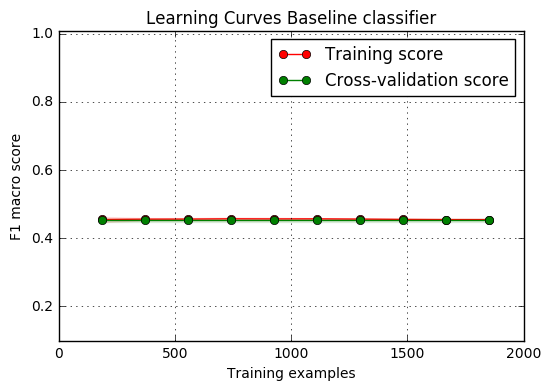

In [21]:
from sklearn.dummy import DummyClassifier

'''load a dummy classifier to make predictions based on the most_frequent class value'''
dummy_classifier_1 = DummyClassifier(strategy="most_frequent")

'''plot learning curve'''
title = "Learning Curves Baseline classifier" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(dummy_classifier_1, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [23]:
'''Train classifier'''
gs_clf = dummy_classifier_1.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_most_freq = gs_clf.predict(test_data_svd)


'''Classification report''' 
report(test_targets,Y_pred_most_freq)


#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------
#
# ham : Negative, spam: Positive
#
# So precision(ham) = TN / (TN + FN) and recall(ham) = TN / (TN + FP)
#    precision(spam) = TP / (TP + FP) and recall(spam) = TP / (TP + FN)
#


# aytos o classifier fainetai na einai isaxios to naive.Ara o naive den exei ekpaideutei polu swsta.

Accuracy: 0.835640138408

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.84      1.00      0.91       483
       spam       0.00      0.00      0.00        95

avg / total       0.70      0.84      0.76       578

---------------------------------------------------------------------
Confusion matrix:
[[483   0]
 [ 95   0]]


C:\Users\fotin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


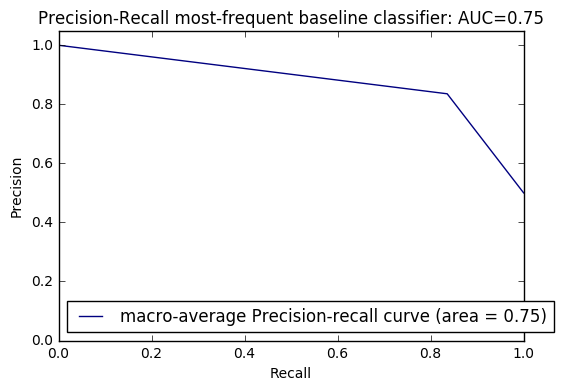

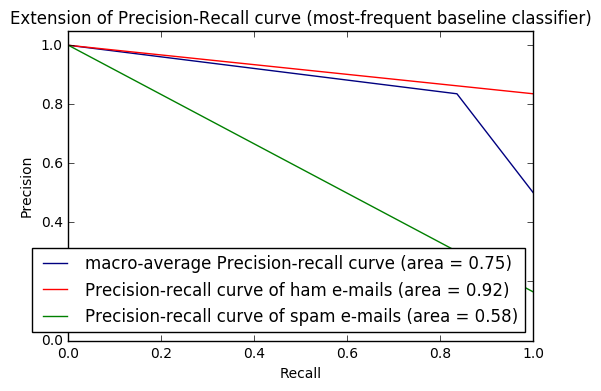

In [25]:
'''plot precision-recall curves'''
precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,'most-frequent baseline classifier',dummy_classifier_1)

2) Now we will use a basile classifier that generates predictions **uniformly at random**.

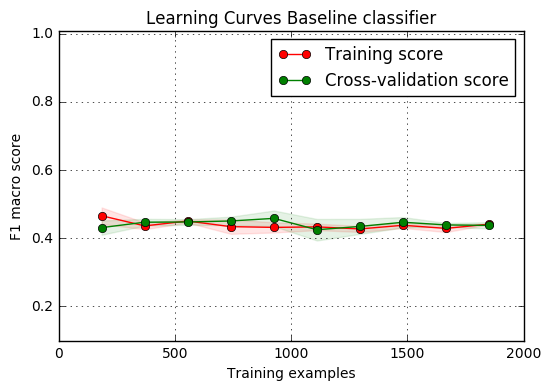

In [26]:
'''load a dummy classifier that generates predictions uniformly at random'''
dummy_classifier_2 = DummyClassifier(strategy="uniform")

'''plot learning curve'''
title = "Learning Curves Baseline classifier" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(dummy_classifier_2, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [27]:
'''Train classifier'''
gs_clf = dummy_classifier_2.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_ = gs_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.48615916955

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.83      0.48      0.61       483
       spam       0.16      0.52      0.25        95

avg / total       0.72      0.49      0.55       578

---------------------------------------------------------------------
Confusion matrix:
[[232 251]
 [ 46  49]]


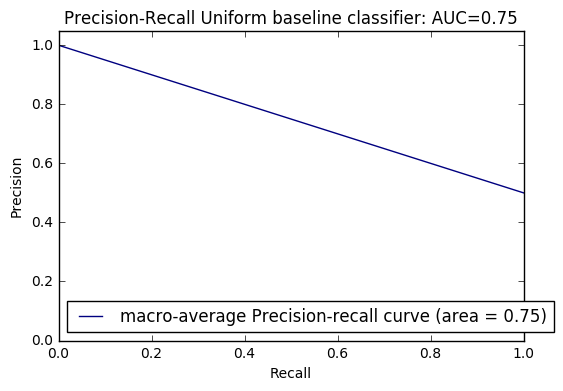

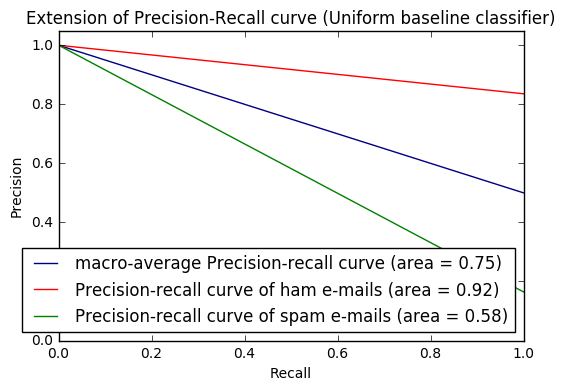

In [28]:
'''plot precision-recall curves'''
precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,'Uniform baseline classifier',dummy_classifier_2)

In [29]:
sum(target1==target2=='ham' for target1,target2 in zip(Y_pred_,test_targets))

232

In [30]:
sum(target1=='spam' for target1 in test_targets)

95

* #### Logistic Regression

In [31]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

start_time = time.time()

# Here C=1/lambda.So larger C ==> weaker regularization(If we want to prevent underfitting)
# Smallar C ==> stronger regularization (If we want to prevent overfitting)
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'fit_intercept':[True,False],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
             'tol':[1e-2,1e-3,1e-4,1e-5]}

'''cross validation'''
# Hyperparameter cv=3  by default, so we make 3-fold cross validation.If we set cv=10 it takes more time to run
gs_clf = GridSearchCV(LogisticRegression(), param_grid,n_jobs=-1)


gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)

124.13826823234558


In [32]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.01,
          verbose=0, warm_start=False)

In [33]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'C': 10, 'fit_intercept': False, 'solver': 'newton-cg', 'tol': 0.01}

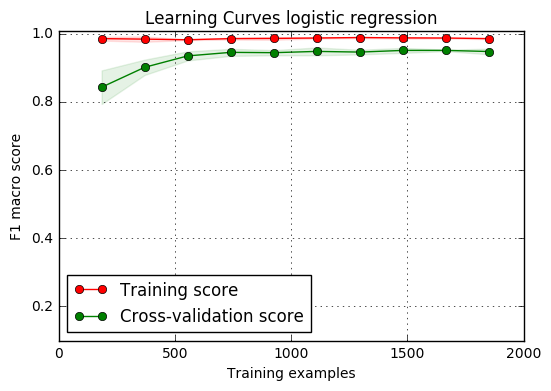

In [34]:
''' Load classifier with best params'''
LR = LogisticRegression(C=gs_clf.best_params_['C'],fit_intercept=gs_clf.best_params_['fit_intercept'],
                        solver=gs_clf.best_params_['solver'],tol=gs_clf.best_params_['tol'])

'''plot learning curve'''
title = "Learning Curves logistic regression" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(LR, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()

In [35]:
'''Using the best parameters to make predictions with logistic regression'''

'''Train classifier''' 
regr_clf = LR.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_regr = regr_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_regr)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------



Accuracy: 0.98615916955

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       483
       spam       1.00      0.92      0.96        95

avg / total       0.99      0.99      0.99       578

---------------------------------------------------------------------
Confusion matrix:
[[483   0]
 [  8  87]]


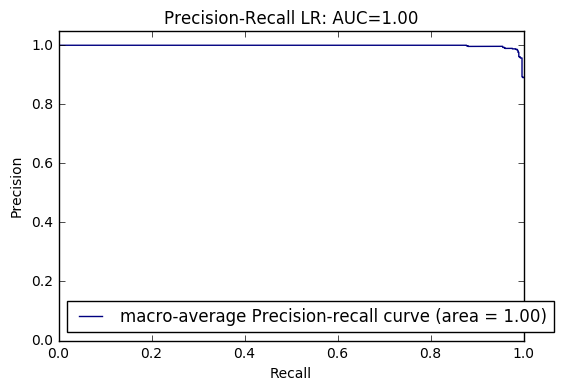

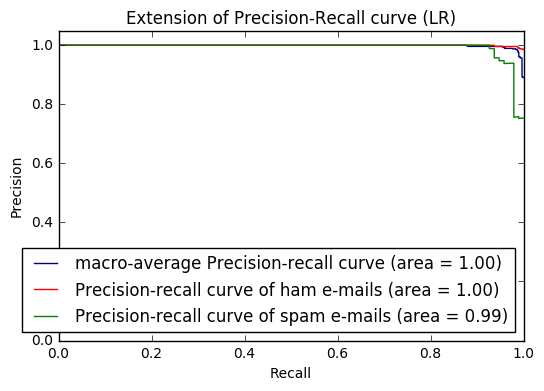

In [36]:
'''plot precision-recall curves'''
precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,'LR',LR)

In [58]:
#sum(target1=='ham' for target1 in test_targets)

* #### KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics


start_time = time.time()

# define the parameter values that should be searched
k_range = list(range(1, 31))

# Another parameter besides k that we might vary is the weights parameters
# uniform (all points in the neighborhood are weighted equally)
# distance (weights closer neighbors more heavily than further neighbors)

param_grid = {'n_neighbors':k_range,'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute'],
             'metric':['euclidean','cityblock','minkowski'],'p':[1,2]}

'''cross validation'''
gs_clf = RandomizedSearchCV(KNeighborsClassifier(),param_grid,n_jobs=-1)

'''train classifier'''
gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)

C:\Users\fotin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\fotin\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


21.392815589904785


In [41]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=24, p=2,
           weights='distance')

In [42]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'algorithm': 'ball_tree',
 'metric': 'minkowski',
 'n_neighbors': 24,
 'p': 2,
 'weights': 'distance'}

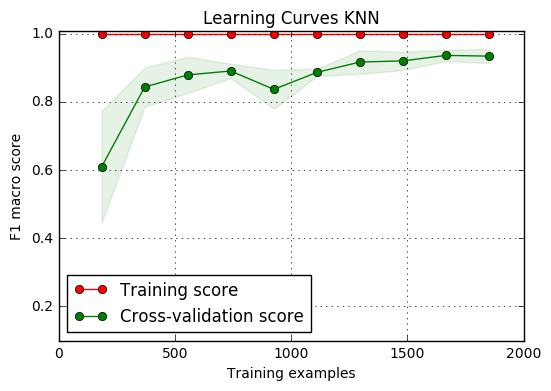

In [43]:
''' Load classifier with best parameters'''
KNN = KNeighborsClassifier(n_neighbors=gs_clf.best_params_['n_neighbors'],weights=gs_clf.best_params_['weights'],algorithm=gs_clf.best_params_['algorithm'],
                           metric=gs_clf.best_params_['metric'],p=gs_clf.best_params_['p'])

'''plot learning curve'''
title = "Learning Curves KNN" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(KNN, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [44]:
'''Using the best parameters to make predictions with KNN'''

'''Train classifier''' 
knn_clf = KNN.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_knn = knn_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_knn)
#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.965397923875

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       483
       spam       0.92      0.86      0.89        95

avg / total       0.96      0.97      0.96       578

---------------------------------------------------------------------
Confusion matrix:
[[476   7]
 [ 13  82]]


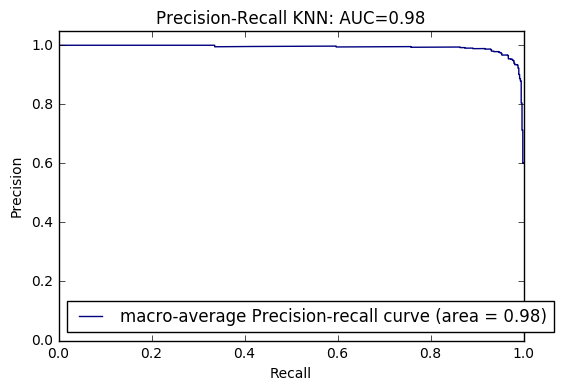

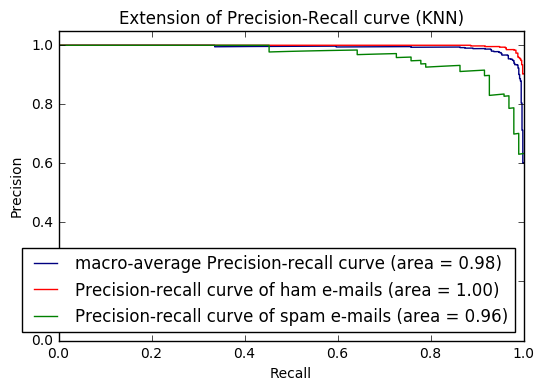

In [45]:
'''plot precision-recall curves'''
precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,'KNN',KNN)

* #### SVM

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats
from sklearn import metrics
from sklearn.metrics import classification_report

start_time = time.time()

# For hyperparameter C see:
# https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel

param_grid = {'C': scipy.stats.expon(scale=100),
              'gamma': scipy.stats.expon(scale=.1), 'kernel':['linear','poly','rbf','sigmoid']}

'''cross validation'''
gs_clf = RandomizedSearchCV(SVC(), param_grid,n_jobs=-1)

'''train classifier'''
gs_clf = gs_clf.fit(train_data_svd,train_targets)

elapsed_time = time.time() - start_time
print(elapsed_time)


23.752535343170166


In [47]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

SVC(C=53.634824828486273, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.15356933447982662,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'C': 53.634824828486273, 'gamma': 0.15356933447982662, 'kernel': 'rbf'}

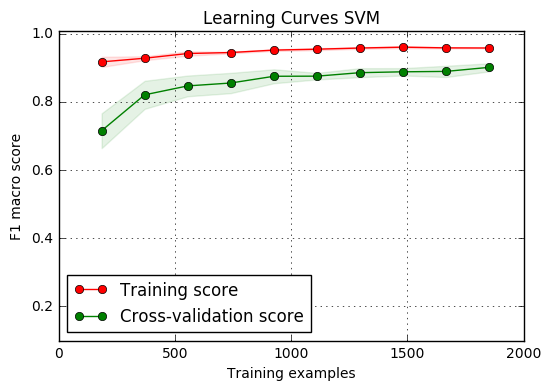

In [49]:
''' Load classifier '''
SVM = SVC(C=gs_clf.best_params_['C'],gamma=gs_clf.best_params_['gamma'],kernel=gs_clf.best_params_['kernel'])

'''plot learning curve'''
title = "Learning Curves SVM" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(SVM, title, train_data_svd,train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [50]:
'''Using the best parameters to make predictions with SVM'''

'''Train classifier''' 
svm_clf = SVM.fit(train_data_svd,train_targets)

'''make prediction'''
Y_pred_svm = svm_clf.predict(test_data_svd)

'''Classification report''' 
report(test_targets,Y_pred_svm)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.967128027682

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.97      0.99      0.98       483
       spam       0.96      0.83      0.89        95

avg / total       0.97      0.97      0.97       578

---------------------------------------------------------------------
Confusion matrix:
[[480   3]
 [ 16  79]]


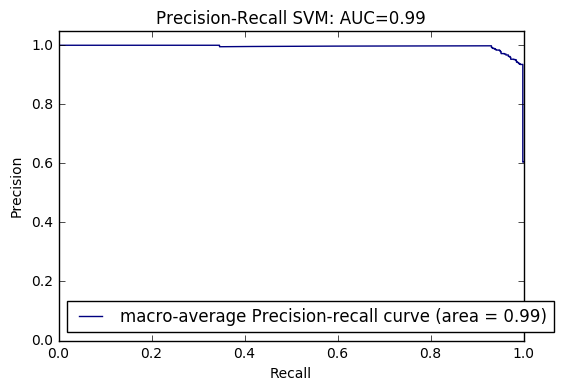

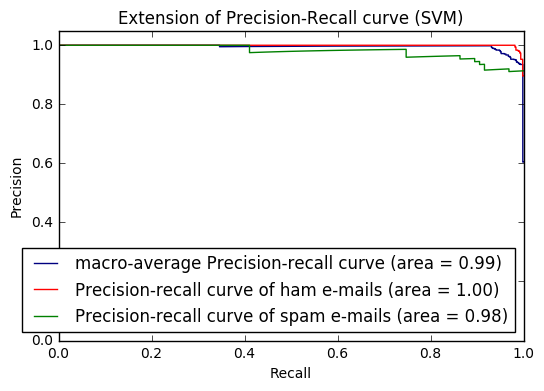

In [51]:
'''plot precision-recall curves'''
precision_recall_curves(train_data_svd,test_data_svd,train_targets,test_targets,'SVM',SVM)

* #### Naive Bayes

There are 3 versions of naive bayes algorithm as we can see from here: http://scikit-learn.org/stable/modules/naive_bayes.html
<ol>
<li>GaussianNB which is not a good fit for document classification.</li>

<li>BernoulliNB which is good for document classification but it accepts only boolean features.</li>
<li>MultinomialNB is good for document classification.It is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, 
fractional counts such as tf-idf also work well.
</li>
</ol>
<br></br>
As SVD may return negative elements, we cannot use MultinomialNB.So we will take tf-idf numpy array without making dimentionality reduction.Of course we do not wait as good results as the previous algorithms gave.

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

# For MultinomialNB you can see: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

param_grid = {'fit_prior':[True,False]}
'''cross validation'''
gs_clf = GridSearchCV(MultinomialNB(), param_grid)

'''train classifier'''
gs_clf = gs_clf.fit(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets)


In [53]:
'''Estimator values.It has default parameters that we did not specify'''
gs_clf.best_estimator_

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
'''Get the best parameter values directrly'''
gs_clf.best_params_

{'fit_prior': True}

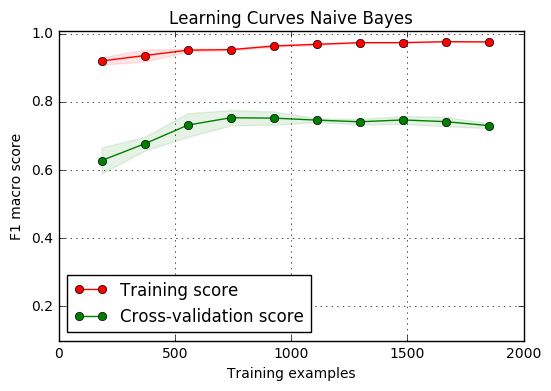

In [55]:
''' Load classifier '''
NaiveBayes = MultinomialNB(fit_prior=gs_clf.best_params_['fit_prior'])

'''plot learning curve'''
title = "Learning Curves Naive Bayes" 
'''
The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. 
Samples are first shuffled and then split into a pair of train and test sets.
Random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.
It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
'''
#n_splits: Number of re-shuffling & splitting iterations.
#random_state: Pseudo-random number generator state used for random sampling.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
plot_learning_curve(NaiveBayes, title, tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets, (0.1, 1.01), cv=cv, n_jobs=-1)
plt.show()


In [56]:
'''Using the best parameters to make predictions with Naive Bayes'''

'''Train classifier''' 
nb_clf = NaiveBayes.fit(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],train_targets)

'''make prediction'''
Y_pred_nb = nb_clf.predict(tf_idf_[int(tf_idf_.shape[0]*.80+1):])

'''Classification report''' 
report(test_targets,Y_pred_nb)

#    confusion matrix

#        PREDICTED
#      ham      spam
#    -------------------
#    |        |        |
#ham |   TN   |  FP    |
#    |--------|--------|
#spam|   FN   |  TP    |
#    |        |        |
#    -------------------


Accuracy: 0.749134948097

------------------------Classification report------------------------

             precision    recall  f1-score   support

        ham       0.96      0.73      0.83       483
       spam       0.38      0.85      0.53        95

avg / total       0.87      0.75      0.78       578

---------------------------------------------------------------------
Confusion matrix:
[[352 131]
 [ 14  81]]


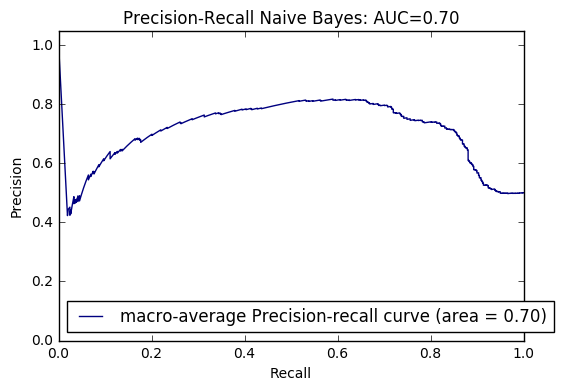

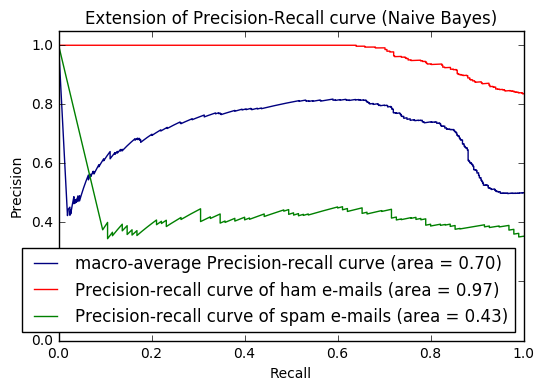

In [57]:
'''plot precision-recall curves'''
precision_recall_curves(tf_idf_[:int((tf_idf_.shape[0]+1)*.80)],tf_idf_[int(tf_idf_.shape[0]*.80+1):],train_targets,test_targets,'Naive Bayes',NaiveBayes)

* ## Word Embeddings

In [ ]:
from nltk.tokenize import word_tokenize

'''
output:
    model: a dictionary which has as key the word and as value the numpy array with one row the corresponding vector
'''
def load_embeddings(gloveFile):
    f = open(gloveFile,'r',encoding='utf8')
    model = {}
    for line in f:
        word = line.split(' ')[0]
        model[word] = np.array(line.split(' ')[1:],dtype='f')
    return model


In [ ]:
#embeddings = load_embeddings('glove.6B.300d.txt')

In [ ]:
'''

#ARGEI POLY...............
start_time = time.time()

# data: processed data
T = np.zeros((len(data),300))

for doc_id, text in enumerate(data):
    word_sequences=word_tokenize(text)
    c =0 
    for word in word_sequences:
        if word in list(embeddings):
            c+=1
            T[doc_id,:]+=embeddings[word]
    if(c>0):
        T[doc_id,:] = T[doc_id,:]/c
            
       
elapsed_time = time.time() - start_time
print(elapsed_time)


'''